# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [244]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
def read_image_and_print_dims(image_path):
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


array([[[180, 196, 209],
        [142, 161, 176],
        [134, 156, 179],
        ..., 
        [136, 154, 178],
        [146, 159, 176],
        [186, 195, 210]],

       [[142, 161, 176],
        [143, 166, 184],
        [134, 160, 183],
        ..., 
        [137, 159, 183],
        [142, 159, 179],
        [148, 161, 178]],

       [[131, 158, 179],
        [133, 161, 183],
        [128, 159, 187],
        ..., 
        [129, 156, 185],
        [136, 158, 182],
        [134, 152, 176]],

       ..., 
       [[120, 121, 125],
        [ 91,  92,  97],
        [ 83,  84,  89],
        ..., 
        [ 88,  89,  93],
        [ 94,  95,  99],
        [120, 121, 125]],

       [[138, 139, 143],
        [105, 106, 110],
        [ 89,  90,  95],
        ..., 
        [ 97,  98, 102],
        [109, 110, 114],
        [139, 140, 144]],

       [[180, 181, 185],
        [140, 141, 145],
        [117, 118, 123],
        ..., 
        [122, 123, 125],
        [140, 141, 143],
        [179, 180,

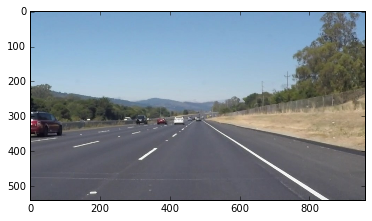

In [4]:
read_image_and_print_dims('test_images/solidWhiteRight.jpg')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [241]:
positive_slope

NameError: name 'positive_slope' is not defined

In [269]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [ ]:
def draw_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    positive_slope_pts_x = [[point[0]] for point in positive_slope_points]
    positive_slope_pts_y = [point[1] for point in positive_slope_points]
    print("Positive Slope X points: ", positive_slope_pts_x, "Length: ", len(positive_slope_pts_x))
    print("Positive Slope Y points: ", positive_slope_pts_y, "Length: ", len(positive_slope_pts_y))
    
    # Fit points to LinearRegression line
    pos_clf = LinearRegression().fit(positive_slope_pts_x, positive_slope_pts_y)
    
    # Get parameters from line
    pos_coeff = pos_clf.coef_[0]
    pos_intercept = pos_clf.intercept_
    print("Coefficients: ", pos_coeff, "Intercept: ", pos_intercept)
    
    # Get starting and ending points of regression line
    print("Two points")
    lines_intersect_x = 480
    point_one = (int(lines_intersect_x), int(lines_intersect_x*pos_coeff+pos_clf.intercept_))
    print("Point one: ", point_one)
    point_two = (imshape[1], int(imshape[1]*pos_coeff+pos_intercept))
    print("Make ints to prep for cv2.line")
    print("Point one: ", point_one, "Point two: ", point_two)
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [293]:
def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    print("X points: ", points_x, "Length: ", len(points_x))
    print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef1, intercept1, intersection_x, imshape=[540,960]):
    
    # Get starting and ending points of regression line, ints.
    point_one = (int(intersection_x), int(intersection_x * coef1 + intercept1))
    print("Point one: ", point_one)
    point_two = (imshape[1], int(imshape[1] * coef1 + intercept1))
    print("Point one: ", point_one, "Point two: ", point_two)
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [291]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # 
    positive_slope_points = []
    negative_slope_points = []
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y2-y1)/(x2-x1)
            point_pair = [x1, y1, x2, y2]
            middle_point = [(x1+x2)/2, (y1+y2)/2]
            # middle_point = [[(x1+x2)/2, (y1+y2)/2]]
            # If line slope in positive
            if slope > 0:
                positive_slope_points.append(middle_point)
            elif slope < 0:
                negative_slope_points.append(middle_point)
    positive_slope_points = np.array(positive_slope_points)
    print("positive slope line points: ", positive_slope_points)
    print("positive slope points dtype: ", positive_slope_points.dtype)
    print("dtype printed")
    
    pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    
    
    # Separate points into X and y to fit LinearRegression model
    positive_slope_pts_x = [[point[0]] for point in positive_slope_points]
    positive_slope_pts_y = [point[1] for point in positive_slope_points]
    print("Positive Slope X points: ", positive_slope_pts_x, "Length: ", len(positive_slope_pts_x))
    print("Positive Slope Y points: ", positive_slope_pts_y, "Length: ", len(positive_slope_pts_y))
    
    # Fit points to LinearRegression line
    pos_clf = LinearRegression().fit(positive_slope_pts_x, positive_slope_pts_y)
    
    # Get parameters from line
    pos_coeff = pos_clf.coef_[0]
    pos_intercept = pos_clf.intercept_
    print("Coefficients: ", pos_coeff, "Intercept: ", pos_intercept)
    
    # Get starting and ending points of regression line
    print("Two points")
    lines_intersect_x = 480
    point_one = (int(lines_intersect_x), int(lines_intersect_x*pos_coeff+pos_clf.intercept_))
    print("Point one: ", point_one)
    point_two = (imshape[1], int(imshape[1]*pos_coeff+pos_intercept))
    print("Make ints to prep for cv2.line")
    print("Point one: ", point_one, "Point two: ", point_two)
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
#    [px1, py1, px2, py2] = cv2.fitLine(positive_slope_points, cv2.DIST_L2,0,0.01,0.01)
#    [nx1, ny1, nx2, ny2] = cv2.fitLine(negative_slope_points, cv2.DIST_L2,0,0.01,0.01)
#    cv2.line(img, (vx, vy), (x, y), color, thickness)

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough lines:  [[[160 539 456 324]]

 [[238 492 460 324]]

 [[710 445 874 539]]

 [[700 446 739 471]]

 [[700 445 844 535]]

 [[179 538 332 422]]

 [[159 538 372 384]]

 [[716 447 875 538]]

 [[408 360 455 325]]

 [[809 512 851 539]]

 [[579 367 627 396]]

 [[415 360 460 325]]

 [[553 355 584 375]]

 [[181 537 211 515]]

 [[577 370 629 400]]

 [[409 364 460 323]]

 [[274 465 298 464]]

 [[214 467 299 461]]

 [[219 462 266 460]]

 [[570 363 631 400]]

 [[702 448 781 497]]]
positive slope line points:  [[ 792.   492. ]
 [ 719.5  458.5]
 [ 772.   490. ]
 [ 795.5  492.5]
 [ 830.   525.5]
 [ 603.   381.5]
 [ 568.5  365. ]
 [ 603.   385. ]
 [ 600.5  381.5]
 [ 741.5  472.5]]
positive slope points dtype:  float64
dtype printed
Positive Slope X points:  [[792.0], [719.5], [772.0], [795.5], [830.0], [603.0], [568.5], [603.0], [600.5], [741.5]] Length:  10
Positive Slope Y points:  [492.0, 458.5, 490.0, 492.5, 525.5, 381.5, 365.0, 385.

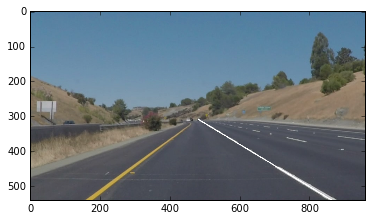

In [292]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    # plt.imshow(greyscaled_image, cmap="gray")
    print("Greyscaled image dims: ", greyscaled_image.shape)
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    # (80,540),(460, 280), (490, 280), (900,540)
    
    # Mask image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    print("Hough output image.shape: ", lines_image.shape)
    plt.imshow(lines_image)
    print("lines_image: ", lines_image)
    
    # TODO: Extrapolate lines
    # [vx, vy, x, y] = cv2.fitLine(lines_image, cv2.DIST_L2,0,0.01,0.01)
    # fitted_lines = cv2.fitLine(hough_rgb_image, cv2.DIST_L2,0,0.01,0.01)
    # plt.imshow(fitted_lines)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    print("hough_rgb.shape: ", hough_rgb_image.shape)
    plt.imshow(hough_rgb_image)
    
    print("hough_rgb.type: ", hough_rgb_image.dtype)
    print(hough_rgb_image)
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    plt.imshow(final_image)
    # return final_image

draw_lane_lines(test_images[3])

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw lines

In [237]:
# Read image
image_path = 'test_images/solidWhiteCurve.jpg'
# image = read_image_and_print_dims(image_path)
image = mpimg.imread(image_path)

In [48]:
image = test_images[3]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)


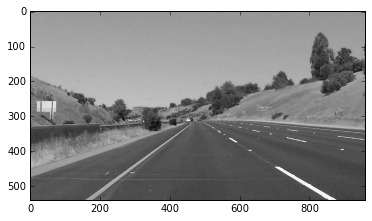

In [49]:
print("image.shape: ", image.shape)
imshape = image.shape
greyscaled_image = grayscale(image)
plt.imshow(greyscaled_image, cmap="gray")
print("Greyscaled image dims: ", greyscaled_image.shape)

Hough output image.shape:  (540, 960)


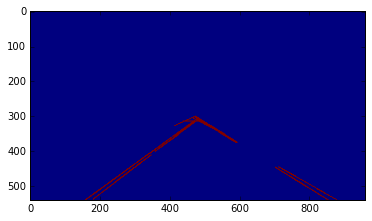

In [205]:
blurred_grey_image = gaussian_blur(greyscaled_image, 5)
edges_image = canny(blurred_grey_image, 50, 150)
# (80,540),(460, 280), (490, 280), (900,540)
vertices = np.array([[(0,imshape[0]),(465, 300), (475, 300), (imshape[1],imshape[0])]], dtype=np.int32)
edges_image_with_mask = region_of_interest(edges_image, vertices)
rho = 2 # distance resolution in pixels of the Hough grid

theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
print("Hough output image.shape: ", lines_image.shape)
plt.imshow(lines_image)

hough_rgb.shape:  (540, 960, 3)


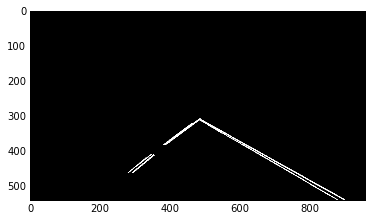

In [10]:
hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
print("hough_rgb.shape: ", hough_rgb_image.shape)
plt.imshow(hough_rgb_image)

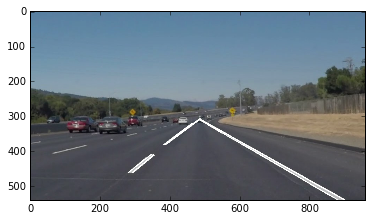

In [11]:
final_image = weighted_img(hough_rgb_image, image)
plt.imshow(final_image)

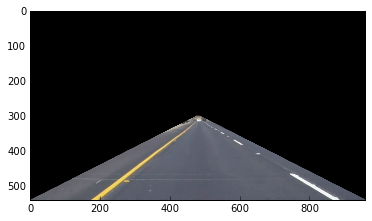

In [134]:
border = 80
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

In [189]:
help(cv2.fitLine)

Help on built-in function fitLine:

fitLine(...)
    fitLine(points, distType, param, reps, aeps[, line]) -> line



In [ ]:
filename = str()
cv2.imwrite(filename, img[, params])

In [20]:
def read_image(image_path):
    return mpimg.imread(image_path)

In [21]:
image_path = 'test_images/solidWhiteCurve.jpg'

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


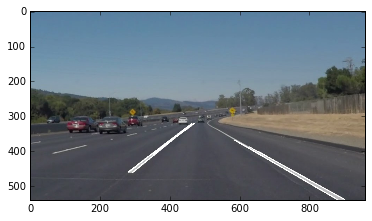

In [167]:
draw_lane_lines(test_images[0])

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


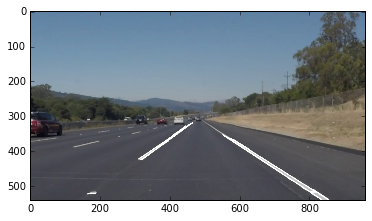

In [177]:
draw_lane_lines(test_images[1])

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


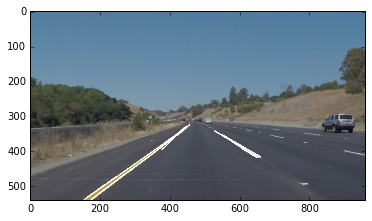

In [156]:
draw_lane_lines(test_images[2])

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


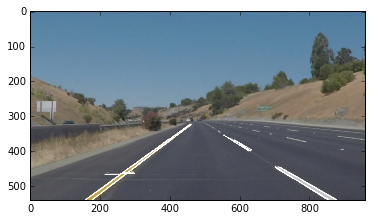

In [147]:
draw_lane_lines(test_images[3])

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


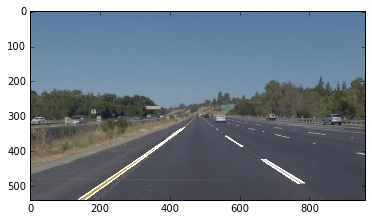

In [157]:
draw_lane_lines(test_images[4])

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


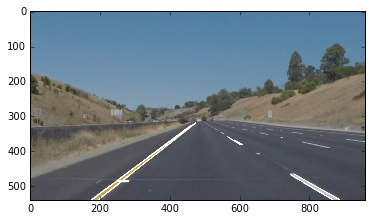

In [149]:
draw_lane_lines(test_images[5])

In [36]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [38]:
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


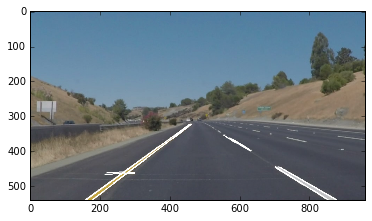

In [181]:
draw_lane_lines(test_images[3])

In [186]:
# TODO: Extrapolate lane lines. When done, add this to draw_lane_lines().

fitted_lines = cv2.fitLine(hough_rgb_image, 10, 0, 5, 0.01)
plt.imshow(fitted_lines)

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/linefit.cpp:603: error: (-215) npoints2 >= 0 || npoints3 >= 0 in function fitLine


In [ ]:
# TODO: Test on all the images in the test_images directory.

In [225]:
help(cv2.findContours)

Help on built-in function findContours:

findContours(...)
    findContours(image, mode, method[, contours[, hierarchy[, offset]]]) -> image, contours, hierarchy



In [228]:
img = cv2.imread('golden_five_pointed_star.jpg', 0)
print("img: ", img)
# img is src
#  threshold(src, thresh, maxval, type[, dst]) -> retval, dst
ret, thresh = cv2.threshold(img, 127, 255, 0)
# ret is retval
print("ret: ", ret)
# thresh is dst
print("thresh: ", thresh)
image, contours, hierarchy = cv2.findContours(thresh, 1, 2)
print("contours: ", contours)
print("hierarchy: ", hierarchy)
cnt = contours[0]
M = cv2.moments(cnt)
print("moments: ", M)

img:  [[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
ret:  127.0
thresh:  [[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
contours:  [array([[[209, 311]],

       [[207, 313]],

       [[206, 313]],

       [[204, 315]],

       [[203, 315]],

       [[200, 318]],

       [[199, 318]],

       [[197, 320]],

       [[196, 320]],

       [[194, 322]],

       [[193, 322]],

       [[191, 324]],

       [[190, 324]],

       [[187, 327]],

       [[186, 327]],

       [[184, 329]],

       [[183, 329]],

       [[181, 331]],

       [[180, 331]],

       [[177, 334]],

       [[176, 334]],

       [[174, 336]],

       [[173, 336]],

       [[171, 338]],

       [[170, 338]],

       [[16

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0%)237568/30241064 bytes (0.8%)565248/30241064 bytes (1.9%)811008/30241064 bytes (2.7%)1122304/30241064 bytes (3.7%)1499136/30241064 bytes (5.0%)1974272/30241064 bytes (6.5%)2318336/30241064 bytes (7.7%)2613248/30241064 bytes (8.6%)2842624/30241064 bytes (9.4%)3072000/30241064 bytes (10.2%)3301376/30241064 bytes (10.9%)3661824/30241064 bytes (12.1%)4087808/30241064 bytes (13.5%)4

In [30]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lane_lines(image)
    print(result.shape)
    return result

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

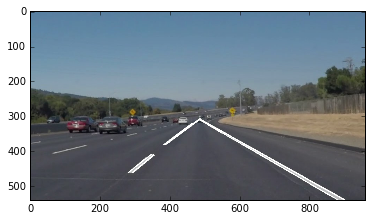

In [31]:
process_image(image)

Let's try the one with the solid white lane on the right first ...

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)


  1%|▏         | 3/222 [00:00<00:10, 21.12it/s]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  3%|▎         | 6/222 [00:00<00:10, 21.43it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  4%|▍         | 9/222 [00:00<00:09, 22.02it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  5%|▌         | 12/222 [00:00<00:09, 22.13it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  7%|▋         | 15/222 [00:00<00:09, 22.19it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  8%|▊         | 18/222 [00:00<00:09, 22.36it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  9%|▉         | 21/222 [00:00<00:08, 22.46it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 11%|█         | 24/222 [00:01<00:08, 22.61it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 12%|█▏        | 27/222 [00:01<00:08, 22.43it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 14%|█▎        | 30/222 [00:01<00:08, 22.64it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 15%|█▍        | 33/222 [00:01<00:08, 22.61it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 16%|█▌        | 36/222 [00:01<00:08, 23.00it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 18%|█▊        | 39/222 [00:01<00:07, 23.09it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 19%|█▉        | 42/222 [00:01<00:07, 23.15it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 20%|██        | 45/222 [00:01<00:07, 23.25it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 22%|██▏       | 48/222 [00:02<00:07, 23.05it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 23%|██▎       | 51/222 [00:02<00:07, 23.17it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 24%|██▍       | 54/222 [00:02<00:07, 23.14it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 26%|██▌       | 57/222 [00:02<00:07, 23.15it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 27%|██▋       | 60/222 [00:02<00:07, 22.66it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 28%|██▊       | 63/222 [00:02<00:07, 22.68it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 30%|██▉       | 66/222 [00:02<00:06, 22.92it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 31%|███       | 69/222 [00:03<00:06, 23.00it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 32%|███▏      | 72/222 [00:03<00:06, 22.81it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 34%|███▍      | 75/222 [00:03<00:06, 22.48it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 35%|███▌      | 78/222 [00:03<00:06, 22.65it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 36%|███▋      | 81/222 [00:03<00:06, 22.71it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 38%|███▊      | 84/222 [00:03<00:06, 22.74it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 39%|███▉      | 87/222 [00:03<00:05, 22.92it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 41%|████      | 90/222 [00:03<00:05, 22.95it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 42%|████▏     | 93/222 [00:04<00:05, 22.80it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 43%|████▎     | 96/222 [00:04<00:05, 22.78it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 45%|████▍     | 99/222 [00:04<00:05, 22.61it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 46%|████▌     | 102/222 [00:04<00:05, 22.61it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 47%|████▋     | 105/222 [00:04<00:05, 22.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)


 49%|████▊     | 108/222 [00:04<00:05, 22.04it/s]

hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 50%|█████     | 111/222 [00:04<00:04, 22.21it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 51%|█████▏    | 114/222 [00:05<00:04, 22.21it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 53%|█████▎    | 117/222 [00:05<00:04, 22.28it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 54%|█████▍    | 120/222 [00:05<00:04, 22.60it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 55%|█████▌    | 123/222 [00:05<00:04, 22.36it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)


 57%|█████▋    | 126/222 [00:05<00:04, 21.98it/s]

hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 58%|█████▊    | 129/222 [00:05<00:04, 22.09it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 59%|█████▉    | 132/222 [00:05<00:04, 22.30it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 62%|██████▏   | 138/222 [00:06<00:03, 22.70it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 64%|██████▎   | 141/222 [00:06<00:03, 22.77it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 65%|██████▍   | 144/222 [00:06<00:03, 22.74it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 66%|██████▌   | 147/222 [00:06<00:03, 22.49it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 69%|██████▉   | 153/222 [00:06<00:02, 23.04it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 70%|███████   | 156/222 [00:06<00:02, 23.33it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 72%|███████▏  | 159/222 [00:07<00:02, 23.27it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 73%|███████▎  | 162/222 [00:07<00:02, 23.39it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 74%|███████▍  | 165/222 [00:07<00:02, 23.17it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 77%|███████▋  | 171/222 [00:07<00:02, 19.90it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 78%|███████▊  | 174/222 [00:07<00:02, 20.70it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 80%|███████▉  | 177/222 [00:07<00:02, 21.39it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 81%|████████  | 180/222 [00:08<00:01, 21.69it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 84%|████████▍ | 186/222 [00:08<00:01, 22.06it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 85%|████████▌ | 189/222 [00:08<00:01, 22.45it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 86%|████████▋ | 192/222 [00:08<00:01, 22.43it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 88%|████████▊ | 195/222 [00:08<00:01, 22.50it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 91%|█████████ | 201/222 [00:08<00:00, 22.66it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 92%|█████████▏| 204/222 [00:09<00:00, 22.68it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 93%|█████████▎| 207/222 [00:09<00:00, 22.69it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 95%|█████████▍| 210/222 [00:09<00:00, 22.77it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 97%|█████████▋| 216/222 [00:09<00:00, 22.53it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 99%|█████████▊| 219/222 [00:09<00:00, 21.33it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


100%|█████████▉| 221/222 [00:09<00:00, 22.41it/s]

(540, 960, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.52 s, sys: 1.77 s, total: 11.3 s
Wall time: 10.3 s


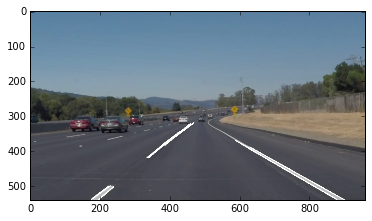

In [160]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [161]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  0%|          | 3/682 [00:00<00:29, 22.66it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  1%|          | 6/682 [00:00<00:29, 23.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  1%|▏         | 9/682 [00:00<00:29, 23.15it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  2%|▏         | 12/682 [00:00<00:29, 23.04it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  2%|▏         | 15/682 [00:00<00:29, 22.59it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  3%|▎         | 18/682 [00:00<00:29, 22.32it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  3%|▎         | 21/682 [00:00<00:29, 22.48it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  4%|▎         | 24/682 [00:01<00:29, 22.67it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  4%|▍         | 27/682 [00:01<00:28, 23.02it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  4%|▍         | 30/682 [00:01<00:28, 22.96it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  5%|▍         | 33/682 [00:01<00:28, 22.73it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  5%|▌         | 36/682 [00:01<00:28, 22.66it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  6%|▌         | 39/682 [00:01<00:28, 22.76it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  6%|▌         | 42/682 [00:01<00:28, 22.75it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  7%|▋         | 45/682 [00:01<00:28, 22.22it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  7%|▋         | 48/682 [00:02<00:28, 22.34it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  7%|▋         | 51/682 [00:02<00:27, 22.59it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  8%|▊         | 54/682 [00:02<00:28, 22.28it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  8%|▊         | 57/682 [00:02<00:27, 22.41it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  9%|▉         | 60/682 [00:02<00:27, 22.27it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


  9%|▉         | 63/682 [00:02<00:27, 22.23it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 10%|▉         | 66/682 [00:02<00:27, 22.09it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 10%|█         | 69/682 [00:03<00:27, 22.37it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 11%|█         | 72/682 [00:03<00:26, 22.75it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 11%|█         | 75/682 [00:03<00:26, 22.74it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 11%|█▏        | 78/682 [00:03<00:26, 22.39it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 12%|█▏        | 81/682 [00:04<00:56, 10.69it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 13%|█▎        | 87/682 [00:04<00:40, 14.71it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 14%|█▎        | 93/682 [00:04<00:32, 17.98it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 14%|█▍        | 96/682 [00:04<00:30, 19.27it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 15%|█▍        | 102/682 [00:04<00:27, 21.24it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 16%|█▌        | 108/682 [00:05<00:25, 22.29it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 16%|█▋        | 111/682 [00:05<00:25, 22.36it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 17%|█▋        | 117/682 [00:05<00:25, 22.56it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 18%|█▊        | 123/682 [00:05<00:24, 22.64it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 18%|█▊        | 126/682 [00:06<00:24, 22.73it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 19%|█▉        | 132/682 [00:06<00:24, 22.74it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 20%|██        | 138/682 [00:06<00:23, 23.09it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 21%|██        | 141/682 [00:06<00:23, 22.85it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 22%|██▏       | 147/682 [00:06<00:23, 22.98it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 22%|██▏       | 153/682 [00:07<00:22, 23.00it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 23%|██▎       | 156/682 [00:07<00:23, 22.86it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 24%|██▍       | 162/682 [00:07<00:22, 22.92it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 25%|██▍       | 168/682 [00:07<00:22, 22.88it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 25%|██▌       | 171/682 [00:08<00:22, 22.87it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 26%|██▌       | 177/682 [00:08<00:22, 22.81it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 27%|██▋       | 183/682 [00:08<00:21, 22.76it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 27%|██▋       | 186/682 [00:08<00:21, 22.58it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 28%|██▊       | 192/682 [00:08<00:21, 22.33it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 29%|██▉       | 198/682 [00:09<00:22, 21.78it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)


 29%|██▉       | 201/682 [00:09<00:21, 21.89it/s]

hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 30%|███       | 207/682 [00:09<00:21, 22.28it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 31%|███       | 210/682 [00:09<00:21, 22.22it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 32%|███▏      | 216/682 [00:10<00:21, 22.16it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 33%|███▎      | 222/682 [00:10<00:20, 22.24it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 33%|███▎      | 225/682 [00:10<00:20, 22.32it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 34%|███▍      | 231/682 [00:10<00:20, 22.27it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)


 34%|███▍      | 234/682 [00:10<00:21, 21.13it/s]

Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 35%|███▌      | 240/682 [00:11<00:20, 21.99it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 36%|███▌      | 246/682 [00:11<00:19, 22.70it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 37%|███▋      | 249/682 [00:11<00:19, 22.56it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 37%|███▋      | 255/682 [00:11<00:18, 22.65it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 38%|███▊      | 261/682 [00:12<00:18, 22.83it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 39%|███▊      | 264/682 [00:12<00:18, 22.87it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 40%|███▉      | 270/682 [00:12<00:18, 22.75it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 40%|████      | 276/682 [00:12<00:17, 23.02it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 41%|████      | 279/682 [00:12<00:17, 23.02it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 42%|████▏     | 285/682 [00:13<00:17, 22.81it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 43%|████▎     | 291/682 [00:13<00:16, 23.01it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 43%|████▎     | 294/682 [00:13<00:16, 23.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 44%|████▍     | 300/682 [00:13<00:16, 22.96it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 45%|████▍     | 306/682 [00:13<00:16, 23.21it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 45%|████▌     | 309/682 [00:14<00:16, 23.12it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 46%|████▌     | 315/682 [00:14<00:15, 23.14it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 47%|████▋     | 321/682 [00:14<00:15, 23.44it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 48%|████▊     | 324/682 [00:14<00:15, 23.55it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 48%|████▊     | 330/682 [00:15<00:15, 23.16it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 49%|████▉     | 336/682 [00:15<00:14, 23.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 50%|████▉     | 339/682 [00:15<00:14, 23.07it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 51%|█████     | 345/682 [00:15<00:14, 22.73it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 51%|█████▏    | 351/682 [00:15<00:14, 22.79it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 52%|█████▏    | 354/682 [00:16<00:14, 22.87it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 53%|█████▎    | 360/682 [00:16<00:13, 23.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 54%|█████▎    | 366/682 [00:16<00:13, 23.05it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 54%|█████▍    | 369/682 [00:16<00:13, 23.11it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 55%|█████▍    | 375/682 [00:16<00:13, 23.07it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 56%|█████▌    | 381/682 [00:17<00:13, 22.89it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 56%|█████▋    | 384/682 [00:17<00:12, 23.12it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 57%|█████▋    | 390/682 [00:17<00:12, 22.99it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 58%|█████▊    | 396/682 [00:17<00:12, 23.25it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 59%|█████▊    | 399/682 [00:18<00:12, 23.17it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 59%|█████▉    | 405/682 [00:18<00:12, 22.89it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 60%|█████▉    | 408/682 [00:18<00:11, 22.96it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 61%|██████    | 414/682 [00:18<00:12, 20.88it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 62%|██████▏   | 420/682 [00:19<00:12, 21.80it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 62%|██████▏   | 423/682 [00:19<00:11, 22.08it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 63%|██████▎   | 429/682 [00:19<00:11, 22.48it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 64%|██████▍   | 435/682 [00:19<00:10, 22.73it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 64%|██████▍   | 438/682 [00:19<00:10, 22.77it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 65%|██████▌   | 444/682 [00:20<00:10, 22.81it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 66%|██████▌   | 450/682 [00:20<00:10, 22.52it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 66%|██████▋   | 453/682 [00:20<00:10, 22.42it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 67%|██████▋   | 459/682 [00:20<00:09, 22.67it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 68%|██████▊   | 465/682 [00:20<00:09, 22.88it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 69%|██████▊   | 468/682 [00:21<00:09, 22.96it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 70%|██████▉   | 474/682 [00:21<00:08, 23.23it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 70%|███████   | 480/682 [00:21<00:08, 23.01it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 71%|███████   | 483/682 [00:21<00:08, 23.08it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 72%|███████▏  | 489/682 [00:22<00:08, 22.96it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 73%|███████▎  | 495/682 [00:22<00:08, 22.78it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 73%|███████▎  | 498/682 [00:22<00:08, 22.65it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 74%|███████▍  | 504/682 [00:22<00:07, 22.64it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 75%|███████▍  | 510/682 [00:22<00:07, 22.08it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)


 75%|███████▌  | 513/682 [00:23<00:07, 22.34it/s]

Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 76%|███████▌  | 519/682 [00:23<00:07, 22.27it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 77%|███████▋  | 522/682 [00:23<00:07, 22.03it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)


 77%|███████▋  | 528/682 [00:23<00:07, 21.41it/s]

hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 78%|███████▊  | 531/682 [00:23<00:07, 21.07it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)


 79%|███████▊  | 537/682 [00:24<00:06, 21.30it/s]

hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 79%|███████▉  | 540/682 [00:24<00:06, 21.54it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 80%|████████  | 546/682 [00:24<00:06, 22.06it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 81%|████████  | 552/682 [00:24<00:05, 22.31it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 81%|████████▏ | 555/682 [00:25<00:05, 22.59it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 82%|████████▏ | 561/682 [00:25<00:05, 22.70it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 83%|████████▎ | 567/682 [00:25<00:05, 22.55it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 84%|████████▎ | 570/682 [00:25<00:04, 22.49it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 84%|████████▍ | 576/682 [00:25<00:04, 22.40it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 85%|████████▌ | 582/682 [00:26<00:04, 22.98it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 86%|████████▌ | 585/682 [00:26<00:04, 22.74it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 87%|████████▋ | 591/682 [00:26<00:03, 22.93it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 88%|████████▊ | 597/682 [00:26<00:03, 22.84it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 88%|████████▊ | 600/682 [00:26<00:03, 22.87it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 89%|████████▉ | 606/682 [00:27<00:03, 22.49it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 90%|████████▉ | 612/682 [00:27<00:03, 21.77it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)


 90%|█████████ | 615/682 [00:27<00:03, 21.31it/s]

Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 91%|█████████ | 621/682 [00:27<00:02, 22.02it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 91%|█████████▏| 624/682 [00:28<00:02, 22.37it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 92%|█████████▏| 630/682 [00:28<00:02, 22.36it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 93%|█████████▎| 636/682 [00:28<00:02, 22.38it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 94%|█████████▎| 639/682 [00:28<00:01, 22.16it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 95%|█████████▍| 645/682 [00:29<00:01, 22.25it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 95%|█████████▌| 651/682 [00:29<00:01, 22.38it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 96%|█████████▌| 654/682 [00:29<00:01, 22.66it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 97%|█████████▋| 660/682 [00:29<00:00, 22.46it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 98%|█████████▊| 666/682 [00:29<00:00, 22.84it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 98%|█████████▊| 669/682 [00:30<00:00, 23.07it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


 99%|█████████▉| 675/682 [00:30<00:00, 22.87it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)


100%|█████████▉| 681/682 [00:30<00:00, 22.83it/s]

(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)
image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)
Hough output image.shape:  (540, 960)
hough_rgb.shape:  (540, 960, 3)
(540, 960, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 29.2 s, sys: 5.81 s, total: 35 s
Wall time: 31 s


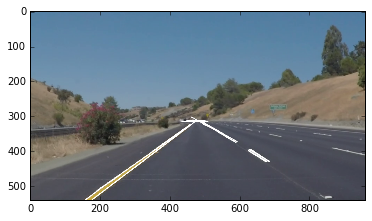

In [34]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))